In [2]:
import utils.cs_vqe_tools as c_tools
import utils.qonversion_tools as qonvert
import utils.bit_tools as bit
import utils.circuit_tools as circ
import utils.linalg_tools as la
import cs_vqe_classes.cs_vqe as c
import cs_vqe_classes.eigenstate as eig

import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
from openfermion.linalg import LinearQubitOperator, get_sparse_operator, get_ground_state
import itertools
from statistics import median

from qiskit.circuit.parameter import Parameter
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.algorithms import VQE
from qiskit import Aer

In [3]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)

singlet_bool = True # Set general UCCSD or singlet UCCSD.

bond_len = 0.772#1.45
atom_1 = 'He'
atom_2 = 'H'
basis = '3-21g'
multiplicity = 1
charge = 1

coordinate_1 = (0.0, 0.0, 0.0)
coordinate_2 = (0.0, 0.0, bond_len)
geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2)]

molecule_data = MolecularData(geometry, basis, multiplicity, charge, description='Test')
#molecule.load()

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Run pyscf.
molecule = run_pyscf(molecule_data,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci)

#molecule.load()
#print(molecule)

ham_f = get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_q = jordan_wigner(ham_f)
print('Hamiltonian:', '\n', ham_q, '\n')

scf = True      # Hartree-Fock.
mp2 = True      # Moller-Plesset 2.
cisd = True     # Configuration interaction singles and doubles.
ccsd = True     # Coupled cluster singles and doubles.
fci = True      # Full configuration interaction.

calculated_molecule = run_pyscf(molecule_data, scf, mp2, cisd, ccsd, fci)

if ccsd:
    ccsd_single_amps = calculated_molecule.ccsd_single_amps
    ccsd_double_amps = calculated_molecule.ccsd_double_amps

num_electrons = calculated_molecule.n_electrons
num_qubits = 2*calculated_molecule.n_orbitals

if singlet_bool:
    # Get singlet UCCSD generator.
    packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
    ucc_sing = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
    #print(ucc_sing)

else:
    # Get general UCCSD operator.
    ucc_op = uccsd_generator(ccsd_single_amps, ccsd_double_amps)
    #print(ucc_op)
    
ucc_q = jordan_wigner(ucc_sing)
ucc = qonvert.QubitOperator_to_dict(ucc_q, num_qubits)
print('UCCSD ansatz:', '\n', ucc_q)

Hamiltonian: 
 (1.1324434021069387+0j) [] +
(-0.02581025441481443+0j) [X0 X1 Y2 Y3] +
(-0.01279993478643725+0j) [X0 X1 Y2 Z3 Z4 Y5] +
(-0.02515964583989765+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Y7] +
(-0.01279993478643725+0j) [X0 X1 X3 X4] +
(-0.02515964583989765+0j) [X0 X1 X3 Z4 Z5 X6] +
(-0.017114528821774805+0j) [X0 X1 Y4 Y5] +
(-0.0009891049103631455+0j) [X0 X1 Y4 Z5 Z6 Y7] +
(-0.0009891049103631455+0j) [X0 X1 X5 X6] +
(-0.05469856574684963+0j) [X0 X1 Y6 Y7] +
(0.02581025441481443+0j) [X0 Y1 Y2 X3] +
(0.01279993478643725+0j) [X0 Y1 Y2 Z3 Z4 X5] +
(0.02515964583989765+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 X7] +
(-0.01279993478643725+0j) [X0 Y1 Y3 X4] +
(-0.02515964583989765+0j) [X0 Y1 Y3 Z4 Z5 X6] +
(0.017114528821774805+0j) [X0 Y1 Y4 X5] +
(0.0009891049103631455+0j) [X0 Y1 Y4 Z5 Z6 X7] +
(-0.0009891049103631455+0j) [X0 Y1 Y5 X6] +
(0.05469856574684963+0j) [X0 Y1 Y6 X7] +
(0.0025779051794105196+0j) [X0 Z1 X2] +
(0.0047661481056806175+0j) [X0 Z1 X2 X3 Z4 X5] +
(-0.009264702923307527+0j) [X0 Z1 X2 X3 Z4 Z5 Z

UCCSD ansatz: 
 0.006478936130102838j [X0 X1 X2 Y3] +
0.006478936130102838j [X0 X1 Y2 X3] +
0.0020562744029710704j [X0 X1 X4 Y5] +
0.0020562744029710704j [X0 X1 Y4 X5] +
0.005083283191416048j [X0 X1 X6 Y7] +
0.005083283191416048j [X0 X1 Y6 X7] +
-0.006478936130102838j [X0 Y1 X2 X3] +
0.006478936130102838j [X0 Y1 Y2 Y3] +
-0.0020562744029710704j [X0 Y1 X4 X5] +
0.0020562744029710704j [X0 Y1 Y4 Y5] +
-0.005083283191416048j [X0 Y1 X6 X7] +
0.005083283191416048j [X0 Y1 Y6 Y7] +
-0.006360390047729467j [X0 Z1 Y2] +
-0.002645411873769119j [X0 Z1 Z2 Z3 Y4] +
0.0009221551709274561j [X0 Z1 Z2 Z3 Z4 Z5 Y6] +
-0.006478936130102838j [Y0 X1 X2 X3] +
0.006478936130102838j [Y0 X1 Y2 Y3] +
-0.0020562744029710704j [Y0 X1 X4 X5] +
0.0020562744029710704j [Y0 X1 Y4 Y5] +
-0.005083283191416048j [Y0 X1 X6 X7] +
0.005083283191416048j [Y0 X1 Y6 Y7] +
-0.006478936130102838j [Y0 Y1 X2 Y3] +
-0.006478936130102838j [Y0 Y1 Y2 X3] +
-0.0020562744029710704j [Y0 Y1 X4 Y5] +
-0.0020562744029710704j [Y0 Y1 Y4 X5] +
-0.0

In [4]:
f = open("hamiltonians/hamiltonians.txt","r")
hamiltonians = ast.literal_eval(f.read())
f.close()

hamiltonians.keys()

dict_keys(['H2-S1_STO-3G_singlet', 'C1-O1_STO-3G_singlet', 'H1-Cl1_STO-3G_singlet', 'H1-Na1_STO-3G_singlet', 'H2-Mg1_STO-3G_singlet', 'H1-F1_3-21G_singlet', 'H1-Li1_3-21G_singlet', 'Be1_STO-3G_singlet', 'H1-F1_STO-3G_singlet', 'H1-Li1_STO-3G_singlet', 'Ar1_STO-3G_singlet', 'F2_STO-3G_singlet', 'H1-O1_STO-3G_singlet', 'H2-Be1_STO-3G_singlet', 'H2-O1_STO-3G_singlet', 'H2_3-21G_singlet', 'H2_6-31G_singlet', 'H3-N1_STO-3G_singlet', 'H4-C1_STO-3G_singlet', 'Mg1_STO-3G_singlet', 'N2_STO-3G_singlet', 'Ne1_STO-3G_singlet', 'O2_STO-3G_singlet', 'H1-Li1-O1_STO-3G_singlet', 'H1-He1_STO-3G_singlet', 'H3_STO-3G_singlet_1+', 'H1-He1_3-21G_singlet_1+', 'H3_3-21G_singlet_1+', 'H4-N1_STO-3G_singlet_1+'])

In [5]:
#speciesname = 'Ne1_STO-3G_singlet'

#num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
#hamiltonian = hamiltonians[speciesname][2] # full Hamiltonian
#terms_noncon = list(hamiltonians[speciesname][3].keys()) # noncontextual part of Hamiltonian, found by greedy DFS
hamiltonian = qonvert.QubitOperator_to_dict(ham_q, num_qubits)#
terms_noncon = c_tools.greedy_dfs(hamiltonian, 1, criterion='weight')[-1]
mol = c.cs_vqe(hamiltonian, terms_noncon, num_qubits)

In [5]:
ham = mol.get_ham(h_type='full', rot=True)
ham_noncon = mol.get_ham(h_type='noncon', rot=True)
ham_context = mol.get_ham(h_type='context', rot=True)

ham_q = qonvert.dict_to_QubitOperator(ham)
ham_noncon_q = qonvert.dict_to_QubitOperator(ham_noncon)
ham_context_q = qonvert.dict_to_QubitOperator(ham_context)

generators = mol.generators(rot=True)
G = generators[0]
A = generators[1]

In [6]:
print('commuting generators:',G, '\n')
print('anticommuting generators:',A, '\n')
#print('Minimising configuration:', gs_noncon[1])

commuting generators: {'ZIIIIIII': 1.0, 'IZIIIIII': 1.0, 'IIZIIIII': 1.0, 'IIIZIIII': -1.0, 'IIIIZIII': 1.0, 'IIIIIZII': 1.0, 'IIIIIIIZ': 1.0} 

anticommuting generators: {'IZZZZZXI': 0.04017216409608734, 'IIIIIIZI': 0.9991927728080489} 



In [7]:
initial_state=mol.init_state(rot=True)
index = bit.bin_to_int(initial_state)
print('Reference state index:', index, initial_state)
gs_noncon_energy = mol.gs_noncon_energy()
#take expectation value algebraically
psi = eig.eigenstate(A, index, num_qubits).construct()
#psi = eig.rotate_state(rotations, psi, num_qubits)
expect = la.expectation(ham_q, psi, num_qubits)

print('<H> w.r.t. simultaneous eigenstate:', expect)
print('Noncontextual approximation:', gs_noncon_energy)
print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match?

Reference state index: 16 00010000
<H> w.r.t. simultaneous eigenstate: (-3.142824749268169+0j)
Noncontextual approximation: -3.1428247492681716
Expectation values match? True


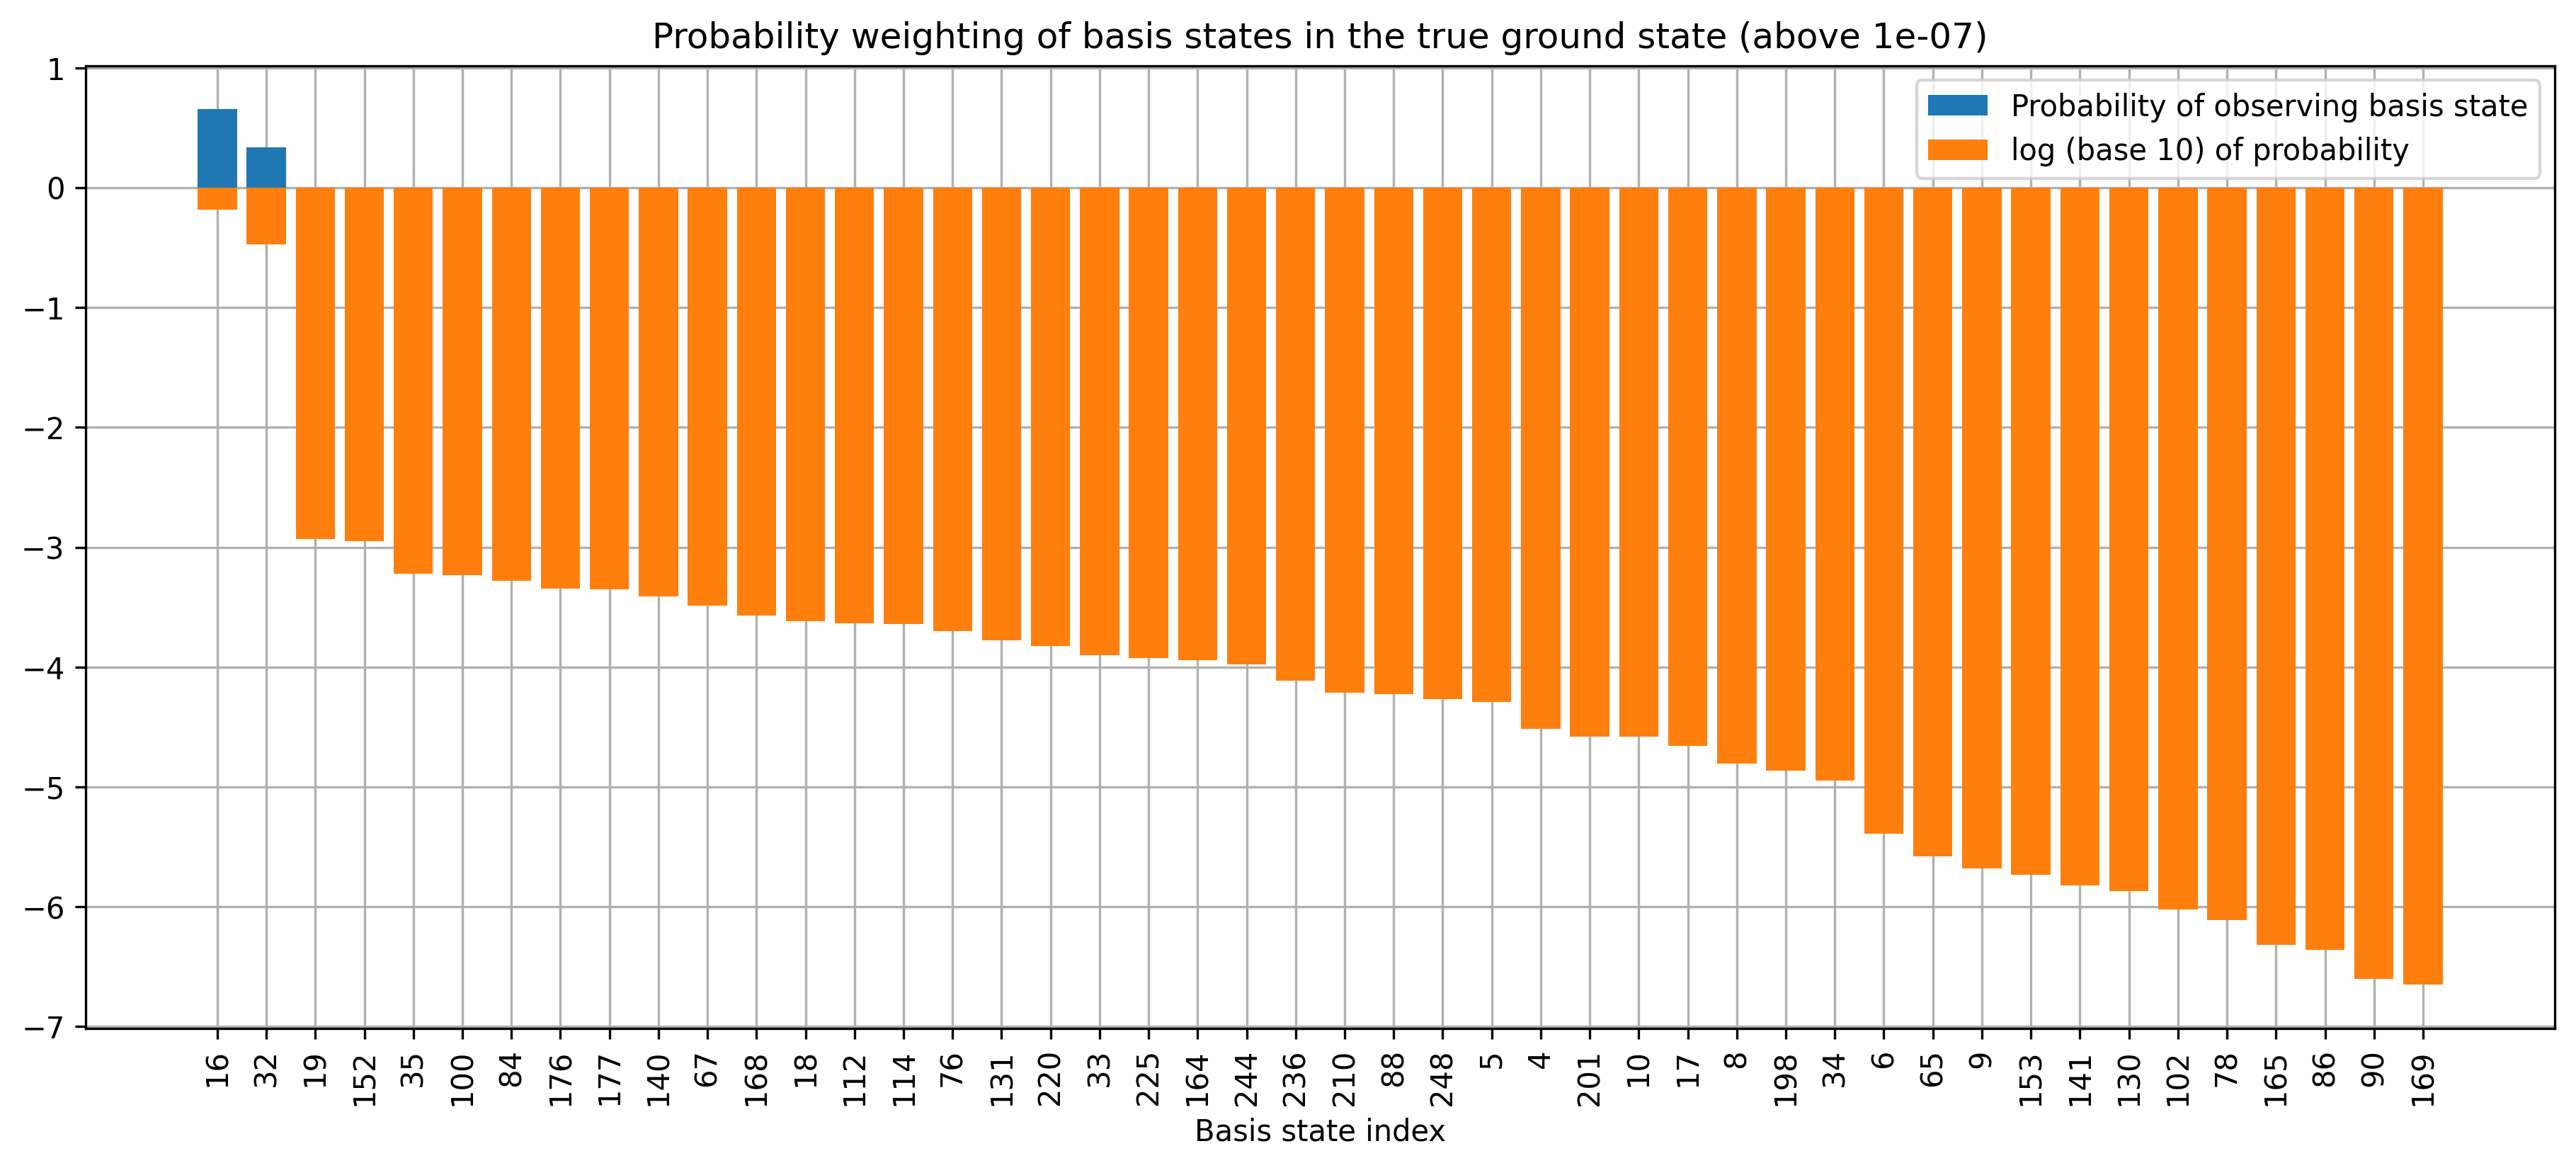

In [8]:
gs_hist = mol.true_gs_hist(threshold=1e-7, rot=True)

removed: []


/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


removed: ['ZIIIIIII']
removed: ['IZIIIIII', 'ZIIIIIII']
removed: ['IIZIIIII', 'IZIIIIII', 'ZIIIIIII']
removed: ['IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII']
removed: ['IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII']
removed: ['IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII']
removed: ['IIIIIIIZ', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII']


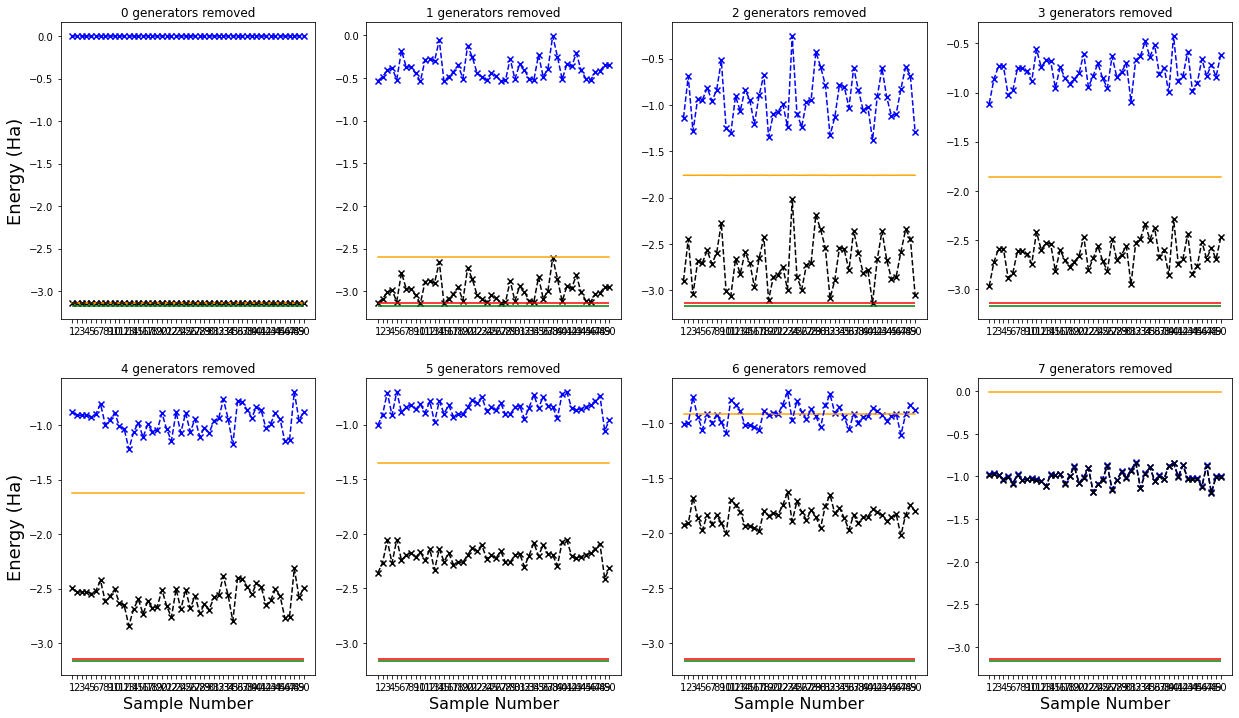

In [9]:
#take expectation value algebraically
from matplotlib import pyplot as plt
shots=50
true_gs=mol.true_gs()[0]

fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (21,12))
grid_pos = [(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]
#grid_pos.reverse()

X=list(range(1, shots+1))

for index, grid in enumerate(grid_pos):
    removed_index = list(range(0, index))
    removed_index.reverse()
    removed_generators = [list(G.keys())[i] for i in removed_index]
    Z_indices = [g.find('Z') for g in removed_generators]
    print('removed:', removed_generators)
    eig_ind = bit.unconstrain(initial_state, Z_indices)
    
    new_ham_noncon, new_ham_context = mol.move_generator(rem_gen=removed_generators, rot=True)
    new_ham_noncon_q = qonvert.dict_to_QubitOperator(new_ham_noncon)
    new_ham_context_q = qonvert.dict_to_QubitOperator(new_ham_context)
    
    random_amplitudes=[]
    for i in range(shots):  
        rand_vec = sorted(la.random_complex_vector(2**len(removed_index)), key=abs)
        rand_vec.reverse()
        random_amplitudes.append(rand_vec)
        
    Y_noncon=[]
    Y_context=[]
    Y_combined=[]
    Y_full=[]

    #A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
    #A = LinearQubitOperator(A_op, num_qubits)

    for amps in random_amplitudes:
        psi = sum([amps[i] * eig.eigenstate(A, index, num_qubits).construct() for i, index in enumerate(eig_ind)])
        
        expect_noncon = la.expectation(new_ham_noncon_q, psi, num_qubits)
        expect_context = la.expectation(new_ham_context_q, psi, num_qubits)
        
        #Y_full.append(expect_full)
        Y_noncon.append(expect_noncon)
        Y_context.append(expect_context)
        Y_combined.append(expect_noncon+expect_context)

        #print(p, expect_noncon + expect_context < gs_noncon_energy)
        #print((np.conjugate(psi)).dot(psi))
        #Verify +1-eigenstate
        #A_psi = A.matvec(psi)
        #print(psi_conj.dot(A_psi))
    
    axs[grid].plot(X, Y_noncon, color='orange')
    axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
    axs[grid].plot(X, Y_context, color='blue', ls='--')
    axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    axs[grid].plot(X, Y_combined, color='black', ls='--')
    #plt.plot(range(shots), Y_combined, color='purple')
    axs[grid].hlines(gs_noncon_energy, 1, shots, color='r')
    axs[grid].hlines(true_gs, 1, shots, color='g')
    
    axs[grid].set_xticks(X)
    axs[grid].set_title("%i generators removed" % abs(index))
    if grid[0] == 1:
        axs[grid].set_xlabel('Sample Number',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 